#  Gibbs sampling model for sparse family test result Covid ,Fixed params

In [2]:
# import neccessary libraries
import numpy as np
import random
import sympy as sym
from sympy import *
from sympy import symbols
from sympy.plotting import plot, plot3d
from datetime import datetime
from scipy.stats import beta
from sklearn.metrics import accuracy_score
import winsound
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

duration = 1000  # milliseconds
freq = 440  # Hz


In [3]:
# function to count the number of the infected neighbores of i at t:
def CNbr(G,X,n,T):
    C=np.zeros((T,n))
    for t in range(T):
        C[t]=G[t].dot(X.T[t])
    return C.T

In [4]:
def transition(X,t,G,F,j,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    c=CNbr(G,X,n,T)[j][t]
    number_of_infected_members_in_family=F.dot(X.T[t])[j]
    k=X[j,t]-2*X[j,t+1]
    if k==0:
        return 1-alpha_-beta_*c-betaf*number_of_infected_members_in_family
    elif k==-2:
        return alpha_+beta_*c+betaf*number_of_infected_members_in_family
    elif k==1:
        return gama_
    else:
        return 1-gama_
    

In [5]:
# Function to obtain the very initial sample of X, using forwad sampling:
def Forward_Sampling(T,n,G,F,param):
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    p0=P
    p1=1-P
    x=int(np.round(((1-P)*n),0))
    X=np.zeros((n,T))  
    idx=np.random.choice(range(n), x)
    X[idx,0]=1
    for t in range(T-1):
        cf=F.dot(X.T[t])
        for i in range(n):
            c=CNbr(G,X,n,T)[i,t]
            if X[i,t]==0:
                p1=(alpha_+beta_*c+betaf*cf[i])
            else:
                p1=(1-gama_)
            X[i,t+1]=np.random.binomial( 1, p1,size=None) 
    return X

In [6]:
def Sample_hidden_state(pos_probs,X,G,F,unique_rows,Y,param,t):
    
    alpha_=param[0]
    beta_=param[1]
    betaf=param[2]
    gama_=param[3]
    theta_0_=param[4]
    theta_1_=param[5]
    
    for i in range(n):
        if t==0:
            p_0,p_1=P,1-P
        else:
            p_0,p_1=1,1
        pow0=np.count_nonzero(Y[i,t]==0)
        pow1=np.count_nonzero(Y[i,t]==1)
        #pow1_=np.count_nonzero(Y[i,t]==-1)
        number_of_members_in_family=np.sum(unique_rows[family_index(i,unique_rows)])
        
        X[i,t]=0
        number_of_infected_members_in_family0=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family0=number_of_members_in_family-number_of_infected_members_in_family0
        p_0=(1/number_of_members_in_family)*p_0*((1-theta_0_)*number_of_healthy_members_in_family0+(1-theta_1_)*number_of_infected_members_in_family0)**pow0*(theta_1_*number_of_infected_members_in_family0+theta_0_*number_of_healthy_members_in_family0)**pow1
        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
    
        if t!=0:
            if X[i,t-1]==0:
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family0)
            else:
                p_0=p_0*gama_
        
        X[i,t]=1
        number_of_infected_members_in_family1=F.dot(X.T[t])[i]
        number_of_healthy_members_in_family1=number_of_members_in_family-number_of_infected_members_in_family1
        p_1=(1/number_of_members_in_family)*p_1*((1-theta_0_)*number_of_healthy_members_in_family1+(1-theta_1_)*number_of_infected_members_in_family1)**pow0*(theta_1_*number_of_infected_members_in_family1+theta_0_*number_of_healthy_members_in_family1)**pow1

        if (t==0):
            c=G[t].dot(X.T[t])[i]
        else:    
            c=G[t-1].dot(X.T[t-1])[i]
        if t!=0:
            if X[i,t-1]==0:
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family1)
            else:
                p_1=p_1*(1-gama_)
        family_members=unique_rows[family_index(i,unique_rows)]
        
        if t!=T-1:        
            X[i,t]=0
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_0=p_0*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_0=p_0*transition(X,t,G,F,j,param)
            X[i,t]=1
            for j in np.where(family_members==1)[0]:
                if j!=i:
                    p_1=p_1*transition(X,t,G,F,j,param)
            for j in np.where(G[t][i]==1)[0]:
                p_1=p_1*transition(X,t,G,F,j,param)
        if t==T-1:
            if X[i,t-1]==0:
                X[i,t]=0
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_0=p_0*(1-alpha_-beta_*c-betaf*number_of_infected_members_in_family)
                X[i,t]=1
                c=G[t].dot(X.T[t])[i]
                number_of_infected_members_in_family=F.dot(X.T[t])[i]
                p_1=p_1*(alpha_+beta_*c+betaf*number_of_infected_members_in_family)
            else:
                p_0=p_0*gama_
                p_1=p_1*(1-gama_)
        if p_0+p_1==0:            
            l=0.5
        else:
            l=p_1/(p_0+p_1)
        if (l<0)|(l>1): 
            print(p_0,p_1)
        X[i,t]=np.random.binomial( 1,  l,size=None)    
        pos_probs[i,t]=l
    return X ,pos_probs   

In [7]:
# Gibbs sampling to obtain X, as new sample of posterior distribution:
def Calculate_X(K,T,X,G,F1,Y,param):
    pos_probs=np.zeros((n,T))
    for k in range(K):
        for t in range(T):
            hidden_states=Sample_hidden_state(pos_probs,X,G,F1,unique_rows,Y,param,t)
            X=hidden_states[0]
            pos_probs=hidden_states[1]
    return X  ,pos_probs              

In [8]:
def Accuracy_(X,X_):
    Xflat = np.hstack(np.hstack(X))
    X_flat = np.hstack(np.hstack(X_))
    result=accuracy_score(Xflat, X_flat,normalize=True)
    return result

# Functions to sample from beta distribution


In [10]:
def add_noise(YF,noise_percent,unique_rows):
    
    number_of_families=unique_rows.shape[0]
    indx=random.sample(range(number_of_families), number_of_families)
    tndx=random.sample(range(T), int(noise_percent*T))
    for i in indx:
        for t in tndx:
            YF[i,t]=(YF[i,t]+1)*(1-YF[i,t])
    return YF        

In [11]:
# funtion to retun related family index of individual i:
def family_index(i,unique_rows):
    for j in range(n):
        if unique_rows[j,i]==1:
            return j

In [13]:
params=np.array([0.001 , 0.0015, 0.0088, 0.2 , 0.013 , 0.97  ])
%store params

Stored 'params' (ndarray)


In [36]:
# Generate synthetic data,G ,Y:
n,T,y=100,100,5
U,K=10,2
P=1
number_families=33
#synthetic_data=Synthetic_Data(n,T,y,params,number_families)
#%store synthetic_data

In [14]:
%store -r synthetic_data
G,YF,X,F,YF_missing =synthetic_data[0],synthetic_data[1],synthetic_data[2],synthetic_data[3],synthetic_data[4]

In [15]:
unique_rows = np.unique(F.T, axis=0)

In [21]:
#calculate y_missing:
Y_missing=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y_missing[i,:]=YF_missing[j,:]


In [19]:
Y=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y[i,:]=YF[j,:]

In [20]:
epsln=0.001
def epsilone(a,b):
    return np.abs(a-b).all()>epsln

In [35]:
# Main code to run entire Gibbs sampling algorithm U times:
def Gibbs(params,T,n,G,F,Y,U,K):

    prob=[] 
    param=[]
    XX=[]
    for u in range(U):
        print("Start Gibbs Sampling:")
        print("************************************************ Iteration",u,"************************************************")
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Current Time is :", current_time)
        cal=Calculate_X(K,T,X,G,F,Y,params)
        X=cal[0]
        pos_probs=cal[1]
        
        prob.append(pos_probs)
        XX.append(X)    
    winsound.Beep(freq, duration) 
    return params, np.array(XX) ,prob

In [37]:
Train=Gibbs(params,T,n,G,F,Y_missing,U,K)

Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 10:44:03
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 1 ************************************************
Current Time is : 11:28:35
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 2 ************************************************
Current Time is : 12:17:16
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 3 ************************************************
Current Time is : 13:02:45
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 4 ************************************************
Current Time is : 17:03:13
Forward_Sampling 36 
 

Start Gibbs Sampling:
***************************************

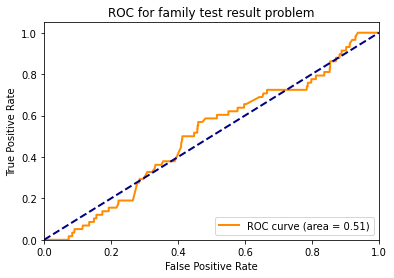

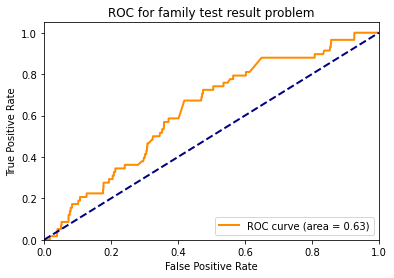

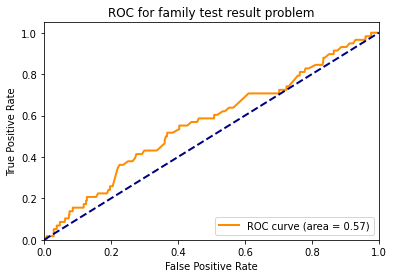

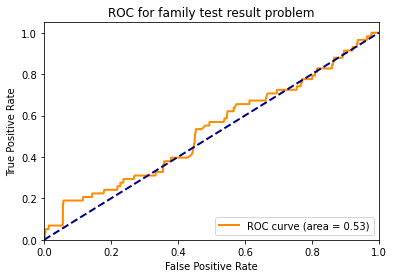

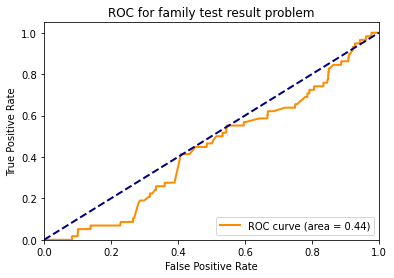

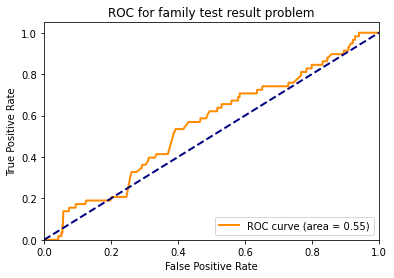

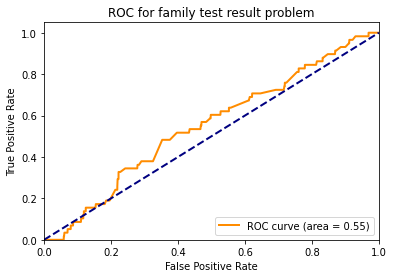

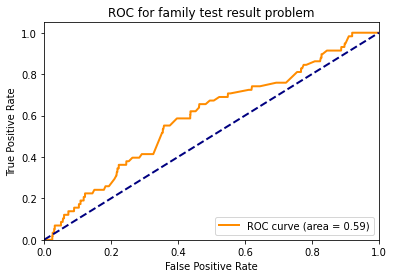

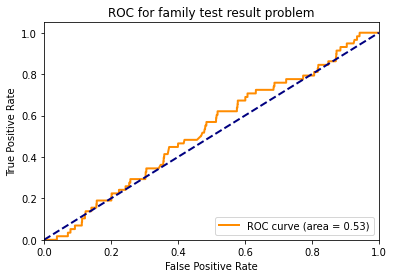

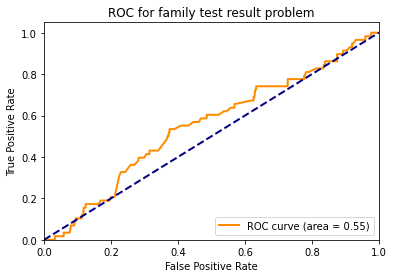

In [39]:
plt.figure()
lw = 2
for j in range(U):
    y_score=np.hstack(Train[2][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [40]:
# function to add noise to observation vector, in order to test the model performance:
def add_noise(YF,noise_percent):
    number_of_families=YF.shape[0]
    YF_noisey=np.copy(YF)
    index=random.sample(range(0,number_of_families*T ), int(number_of_families*T*noise_percent))
    for j in index:
        i=int(j/T)
        t=j-i*T
        YF_noisey[i,t]=(1+YF[i,t])*(1-YF[i,t])
    return YF_noisey 

In [41]:
noise_percent=.1
YF_noisey=add_noise(YF_missing,noise_percent)

In [42]:
Y_noisey=np.zeros((n,T))
for i in range(n):
    for j in range(unique_rows.shape[0]):
        if unique_rows[j,i]==1:
            Y_noisey[i,:]=YF_noisey[j,:]

In [ ]:
Test=Gibbs(params,T,n,G,F,Y_noisey,U,K)

Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 0 ************************************************
Current Time is : 11:33:02
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 1 ************************************************
Current Time is : 12:16:54
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 2 ************************************************
Current Time is : 13:20:02
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 3 ************************************************
Current Time is : 14:05:22
Forward_Sampling 36 
 

Start Gibbs Sampling:
************************************************ Iteration 4 ************************************************
Current Time is : 15:02:14
Forward_Sampling 36 
 

Start Gibbs Sampling:
***************************************

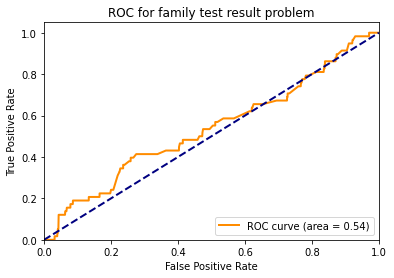

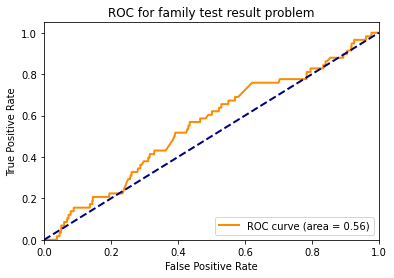

In [39]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Test[1][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [40]:
print("alpha,beta,betaf,gama,t0,t1,n,T,K,J,U",Train[0],n,T,K,J,U)

alpha,beta,betaf,gama,t0,t1,n,T,K,J,U [0.001  0.002  0.0074 0.15   0.011  0.968 ] 100 100 2 2 2


In [ ]:
def show_TPR_by_time(X_true,X_score,T):
    TP,FN,TPR=np.zeros((T)),np.zeros((T)),np.zeros((T))
    for t in range(T):
        TP[t]=np.count_nonzero(np.multiply(X_true,X_score).T[t]==1)
        FN[t]=np.count_nonzero((X_true-2*X_score).T[t]==1)
        if (TP[t]+FN[t])!=0:
            TPR[t]=TP[t]/(TP[t]+FN[t])
        #print(TP[t],FN[t])
        #plt.plot(t,TPR[t],'go--', linewidth=2, markersize=1)  
    plt.plot(range(T),TPR) 
    plt.show() 

In [ ]:
show_TPR_by_time(X,Train[2][0],T)

In [ ]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Test[1][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plt.figure()
lw = 2
for j in range(J):
    y_score=np.hstack(Train[2][j])
    y_test=np.hstack(X)
    fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC for family test result problem")
    plt.legend(loc="lower right")
    plt.show()

# Adding noise to YF:

In [ ]:
def estimate_Y(Family,X,params):
    theta_0=params[4]
    theta_1=params[5]
    unique_rows = np.unique(Family, axis=0)
    nf=unique_rows.shape[0]
    YF=np.zeros((nf,T))
    for t in range(T):
        for i in range(nf):
            number_of_members_in_family=np.sum(unique_rows[i])
            number_of_infected_members_in_family=unique_rows[i].dot(X.T[t])
            number_of_healthy_members_in_family= number_of_members_in_family-number_of_infected_members_in_family
            py1=(theta_0_*number_of_healthy_members_in_family+theta_1_*number_of_infected_members_in_family)/ number_of_members_in_family
            py0=((1-theta_0_)*number_of_healthy_members_in_family+(1-theta_1_)*number_of_infected_members_in_family)/ number_of_members_in_family
            l=py1/(py1+py0)
            YF[i,t]=np.random.binomial( 1, l,size=None)
    return YF